# Setup





In [1]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Navigate to folder containing project
import os
os.chdir("drive/My Drive/COMP 551/Projects/Project3")

# VGG16, Xception and InceptionResNetV2 Ensemble 


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import datetime
from sklearn.model_selection import train_test_split
import pandas as pd 

# Using pre-trained models
from keras.applications import VGG16, VGG19, InceptionResNetV2, Xception, NASNetLarge
from keras import datasets, optimizers
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Average, concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.engine import training

Using TensorFlow backend.


In [0]:
from keras.models import load_model 

# Load models for ensemble
vgg16 = load_model("models/VGG16_final_09782_avgpool_sgd_lr0001_30epochs_bs64.h5")
xception = load_model("models/Xception_09712_sgd_lr00005_30epochs_bs32.h5")
resnet = load_model("models/InceptionResNetV2_final.h5")

vgg16.name = 'vgg16'
xception.name = 'xception'
resnet.name = 'inceptionresnetv2'

# Make a list of models 
models = [vgg16, xception, resnet]


In [0]:
import random

# Rename all layers to be able to concatenate models (since layers with same name are not allowed)
for model in models:
  for layer in model.layers:
      layer.name = str(random.randint(0,100000000000))

In [0]:
# Initialize optimizer
learning_rate = 1e-3
optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9) 

In [0]:
# Initialize number of epochs, batch_size and validation split 
WARMUP = 10
EPOCHS = 30
batch_size = 64

In [0]:
def avg_ensemble(models):    
    # Create an output layer with output layer of all model
    outputs = [model.outputs[0] for model in models]
    outputs = Average()(outputs)
    
    # Create model
    model = Model(inputs=[model.input for model in models], outputs=outputs, name='VGG - Xception - InceptionResNetV2 Ensemble')    

    # Initialize optimizer
    learning_rate = 5e-4
    optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9) 
    
    # Compile model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    
    # Print a summary of the model
    model.summary()

    return model 

In [0]:
# Create average ensemble of VGG16, Xception and InceptionResNetV2
avg_model = avg_ensemble(models)
avg_model.save("models/average_ensemble_model.h5")

Model: "VGG - Xception - InceptionResNetV2 Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
9203256206 (InputLayer)         (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
7709601157 (Conv2D)             (None, 63, 63, 32)   864         9203256206[0][0]                 
__________________________________________________________________________________________________
91732791461 (BatchNormalization (None, 63, 63, 32)   96          7709601157[0][0]                 
__________________________________________________________________________________________________
16435266185 (Activation)        (None, 63, 63, 32)   0           91732791461[0][0]                
________________________________________________________

In [0]:
# Read data 
x_train = pd.read_pickle("data/x_train.pkl")
x_valid = pd.read_pickle("data/x_valid.pkl")
y_train = pd.read_pickle("data/y_train.pkl")
y_valid = pd.read_pickle("data/y_valid.pkl")

# Convert training/valid images from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)
x_valid = np.stack((x_valid,x_valid,x_valid), axis=-1)

# Image dimensions 
image_size = x_train[0].shape[0]
num_channels = x_train[0].shape[2]
print("Image size: {0}\nNumber of channels: {1}".format(image_size, num_channels))

Image size: 128
Number of channels: 3


In [0]:
# Construct the training image generator to perform data augmentation (NOTE: since we are working numbers, it is important to set the rotation and the horizontal_flip to 0 and False respectively).
datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.10,
	width_shift_range=0.05, height_shift_range=0.05, shear_range=0,
	horizontal_flip=False,vertical_flip=False, fill_mode="nearest")

In [0]:
# Fit data generator on training data for ZCA whitening
datagen.fit(x_train)

In [0]:
# Create an ensemble of VGG16, Xception and InceptionResNetV2
outputs = [model.outputs[0] for model in models]
outputs = concatenate(outputs)    
outputs = Dense(32, activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(16, activation='relu')(outputs)
outputs = Dense(10, activation='softmax')(outputs)

model = Model(inputs=[model.input for model in models], outputs=outputs, name='VGG - Xception - InceptionResNetV2 Ensemble')    

# Compile model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Print a summary of the model
model.summary()

Model: "VGG - Xception - InceptionResNetV2 Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
40570297898 (InputLayer)        (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
66537108486 (Conv2D)            (None, 63, 63, 32)   864         40570297898[0][0]                
__________________________________________________________________________________________________
54661945403 (BatchNormalization (None, 63, 63, 32)   96          66537108486[0][0]                
__________________________________________________________________________________________________
32165057114 (Activation)        (None, 63, 63, 32)   0           54661945403[0][0]                
________________________________________________________

In [0]:
# Visualize layer names and layer indices to see how many layers we should unfreeze for Ensemble
for i, layer in enumerate(model.layers):  
  print(i, layer.name, layer.trainable)

0 40570297898 False
1 66537108486 True
2 54661945403 True
3 32165057114 True
4 92979982061 True
5 82900416469 True
6 44996407409 True
7 20283401517 True
8 12608311966 True
9 51642797301 True
10 14980996936 True
11 97249324280 True
12 15821960372 True
13 76594311660 True
14 74941849821 True
15 32312078055 True
16 69009724526 True
17 42905927845 True
18 61279718608 True
19 31219010689 True
20 74842627076 True
21 28294553626 True
22 90758709329 True
23 65286014374 True
24 91516077915 True
25 96463649659 True
26 37988662092 True
27 83084565143 True
28 42554851327 True
29 30699328665 True
30 93916905528 True
31 1185526409 True
32 15289335130 True
33 23508958500 True
34 65018647170 True
35 57636923242 True
36 81348695618 True
37 17747592064 True
38 3727785310 True
39 19788979012 True
40 54116099011 True
41 26766652685 True
42 47300881598 True
43 57945810046 True
44 91035119934 True
45 68699711188 True
46 21281997490 True
47 38216145273 True
48 84361065188 True
49 67990279369 True
50 70537336

In [0]:
# Freeze all layers except last three layers
for layer in model.layers[-4:]:
  layer.trainable = True
for layer in model.layers[:-4]:
  layer.trainable = False

# Display trainable layers
for layer in model.layers:
  print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7fc55df140f0>: False
<keras.layers.convolutional.Conv2D object at 0x7fc55df14160>: False
<keras.layers.normalization.BatchNormalization object at 0x7fc55df14198>: False
<keras.layers.core.Activation object at 0x7fc55df144a8>: False
<keras.layers.convolutional.Conv2D object at 0x7fc55df14588>: False
<keras.layers.normalization.BatchNormalization object at 0x7fc55df145c0>: False
<keras.layers.core.Activation object at 0x7fc55df14748>: False
<keras.layers.convolutional.Conv2D object at 0x7fc55df14860>: False
<keras.layers.normalization.BatchNormalization object at 0x7fc55df14898>: False
<keras.layers.core.Activation object at 0x7fc55df14a20>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fc55df14b38>: False
<keras.layers.convolutional.Conv2D object at 0x7fc55df14b70>: False
<keras.layers.normalization.BatchNormalization object at 0x7fc55df14c18>: False
<keras.layers.core.Activation object at 0x7fc55df14da0>: False
<keras.layers.conv

In [0]:
# Save model 
model.save("models/stacking_ensemble.h5")

In [8]:
from keras.models import load_model
# Load model
model = load_model("models/stacking_ensemble3DL.h5")














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
# Load data 
x = pd.read_pickle('data/preprocessed_train_max_x.pkl')
y = pd.read_csv("data/train_max_y.csv")['Label']

# Grayscale to RGB
x = np.array(np.stack((x,x,x), axis=-1))

In [10]:
# Recompile the model for these modifications to take effect. SGD is used with a low learning rate to fine tune.
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Print a summary of the model
model.summary()

# Train model again (fine-tuning Dense layers)
history = model.fit([x,x,x],y, batch_size=batch_size,use_multiprocessing=True, epochs=EPOCHS)

Model: "VGG - Xception - InceptionResNetV2 Ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
22774556475 (InputLayer)        (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
63917764672 (Conv2D)            (None, 63, 63, 32)   864         22774556475[0][0]                
__________________________________________________________________________________________________
84424067320 (BatchNormalization (None, 63, 63, 32)   96          63917764672[0][0]                
__________________________________________________________________________________________________
90299426223 (Activation)        (None, 63, 63, 32)   0           84424067320[0][0]                
________________________________________________________

In [0]:
# Save model 
model.save("models/final_stacking_model.h5")

KeyError: ignored

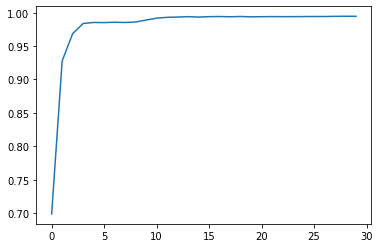

In [0]:
# Plot history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Stacking Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/stacking_{0}acc_sgd_lr{1}_{2}epochs_bs{3}.png'.format(max(history.history['val_acc']), learning_rate, EPOCHS, batch_size))
plt.show()

In [0]:
# Plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/stacking_{0}loss_sgd_lr{1}_{2}epochs_bs{3}.png'.format(min(history.history['val_loss']), learning_rate, EPOCHS, batch_size))
plt.show()

In [0]:
def predict(model):
  """Method that takes as input a model and stores its predictions in a csv file."""
  import datetime

  test_img = pd.read_pickle("data/preprocessed_test_max_x.pkl")

  # Convert tests images from grayscale to rgb (3 channels)
  test_img = np.stack((test_img,test_img,test_img), axis=-1)

  # Predict 
  preds = model.predict([test_img,test_img,test_img]).argmax(axis=-1)

  # Create DataFrame with predictions
  df = pd.DataFrame({"Id": list(range(len(preds))), "Label": preds})

  # Save predictions 
  df.to_csv("predictions/predictions{}.csv".format(datetime.datetime.now()), index=False)

  return preds 

In [0]:
# Generate predictions
preds = predict(model)